In [184]:
from zipfile import ZipFile
import pandas as pd
import kaggle
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [190]:
# https://www.kaggle.com/kimjihoo/coronavirusdataset
kaggle.api.authenticate()
kg_url='kimjihoo/coronavirusdataset'
files=['patient.csv','route.csv','time.csv']

In [191]:
for file in files:
    kaggle.api.dataset_download_file(kg_url,file,force=True, path='data')#force =Trure rewrites file if excist


In [192]:
df_patient = pd.read_csv('data/'+files[0])
df_route = pd.read_csv('data/'+files[1])
df_time = pd.read_csv('data/'+files[2])

In [198]:
#df_time.rename(columns={'176':'Date'},inplace=True)
df_time['date']=pd.to_datetime(df_time['date'])

In [199]:
df_patient['id'].nunique(), df_patient.shape

(7382, (7382, 15))

In [200]:
df_route['id'].nunique(), df_route.shape

(55, (212, 7))

In [201]:
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7382 entries, 0 to 7381
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7382 non-null   int64  
 1   sex               657 non-null    object 
 2   birth_year        417 non-null    float64
 3   country           7381 non-null   object 
 4   region            418 non-null    object 
 5   disease           26 non-null     float64
 6   group             83 non-null     object 
 7   infection_reason  144 non-null    object 
 8   infection_order   35 non-null     float64
 9   infected_by       70 non-null     float64
 10  contact_number    50 non-null     float64
 11  confirmed_date    7381 non-null   object 
 12  released_date     55 non-null     object 
 13  deceased_date     32 non-null     object 
 14  state             7381 non-null   object 
dtypes: float64(5), int64(1), object(9)
memory usage: 865.2+ KB


In [202]:
date_clm = ['confirmed_date','released_date','deceased_date']
for clm in date_clm:
    df_patient[clm]=pd.to_datetime(df_patient[clm])

In [203]:
df_patient['duration']=df_patient['released_date']-df_patient['confirmed_date']
df_patient['duration_death']=df_patient['deceased_date']-df_patient['confirmed_date']
df_patient['age'] =2019- df_patient['birth_year']

Text(0.5, 0, 'age')

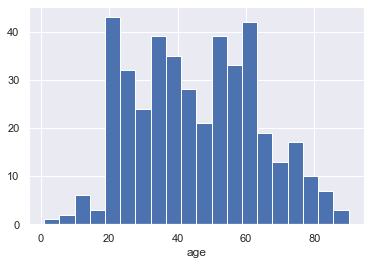

In [204]:
df_patient['age'].hist(bins=20)
plt.xlabel('age')

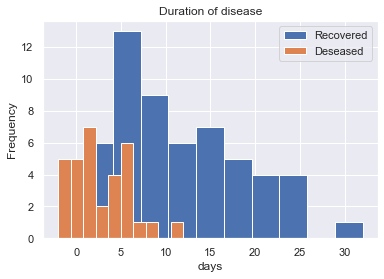

In [205]:
df_patient['duration'].astype('timedelta64[D]').plot.hist(label='Recovered')
df_patient['duration_death'].astype('timedelta64[D]').plot.hist(label='Deseased')
plt.xlabel('days')
plt.legend()
plt.title('Duration of disease')
plt.show()

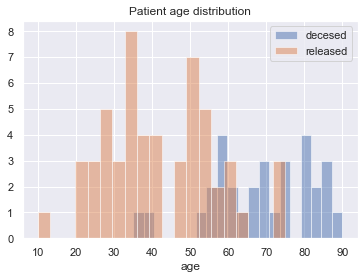

In [206]:
df_patient[df_patient['state']=='deceased']['age'].hist(bins=20,alpha=0.5,label='decesed')
df_patient[df_patient['state']=='released']['age'].hist(bins=20,alpha=0.5,label='released')
plt.xlabel('age')
plt.title('Patient age distribution')
plt.legend();

In [207]:
df_time=df_time.set_index('date')


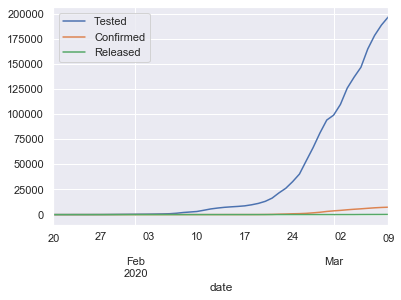

In [208]:
df_time['acc_test'].plot(label='Tested')
df_time['acc_confirmed'].plot(label='Confirmed')
df_time['acc_released'].plot(label='Released')
plt.legend()
